In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters

import blackjax

In [2]:
num_points = 100
M = 2
x = np.linspace(-5, 5, num_points)
f = 4*x + 5
y = f + np.random.randn(num_points)

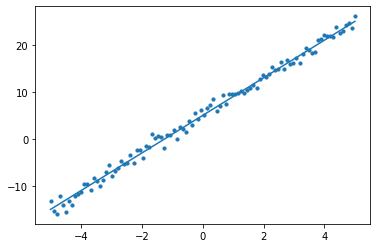

In [3]:
plt.scatter(x, y, s = 10)
plt.plot(x, f)

In [4]:
import distrax

In [5]:
def logprob_fn(theta):
    dist = distrax.MultivariateNormalDiag(loc = x*theta[1] + theta[0], scale_diag=jnp.ones(num_points))
    return dist.log_prob(y)

In [6]:
theta_init = jnp.array([0., 0.])

In [7]:
logprob_fn([5.0, 4.0]), logprob_fn([4.0, 4.0]), logprob_fn([.0, .0]), 

(DeviceArray(-141.48395414, dtype=float64),
 DeviceArray(-201.48346933, dtype=float64),
 DeviceArray(-8294.64003892, dtype=float64))

In [8]:
def logprob_fn_analytical(theta):
    # Assuming s = 1
    err = (y-x*theta[1] - theta[0])
    return -1*(num_points*jnp.log(2*np.pi)/2 + err@err/2)

https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf

In [9]:
logprob_fn([5.0, 4.0]), logprob_fn([4.0, 4.0]), logprob_fn([.0, .0]), 

(DeviceArray(-141.48395414, dtype=float64),
 DeviceArray(-201.48346933, dtype=float64),
 DeviceArray(-8294.64003892, dtype=float64))

Clearly, our implementation of (negative) logprob_fn seems to be correct. 

## MCMC 

Code adapted (reused from): https://blackjax-devs.github.io/blackjax/examples/LogisticRegression.html

In [10]:
rng_key = random.PRNGKey(314)

theta0 = random.multivariate_normal(rng_key, 0.1 + jnp.zeros(M), jnp.eye(M))

rmh = blackjax.rmh(logprob_fn, sigma=jnp.ones(M) * 0.1)
initial_state = rmh.init(theta0)

In [11]:
initial_state

RMHState(position=DeviceArray([-0.0621457,  0.6826571], dtype=float64), log_probability=DeviceArray(-6194.28920635, dtype=float64))

In [12]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [13]:
_, rng_key = random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 5_000)

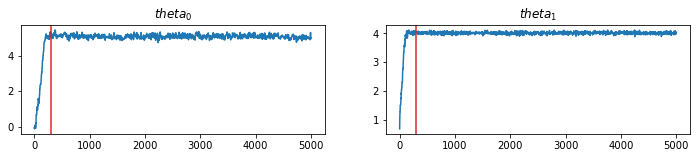

In [14]:
burnin = 300

fig, ax = plt.subplots(1, M, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$theta_{i}$")
    axi.axvline(x=burnin, c="tab:red")
plt.show()